<a href="https://colab.research.google.com/github/thehimalayanleo/Algorithm-Practice/blob/master/EFH_RBM_Homework7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch

In [53]:
# Global Parameters
n_epochs = 3
batch_size_train = 128
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [54]:
# import MNIST and load train/test dataloaders
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),])
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform), batch_size=batch_size_train, num_workers=0, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform), batch_size=batch_size_test, num_workers=0, shuffle=True)

In [4]:
# View first batch and confirm shapes
dataset = enumerate(train_loader)
indx, (data, label) = next(dataset)
print(indx, data.shape, label.shape)

0 torch.Size([128, 1, 28, 28]) torch.Size([128])


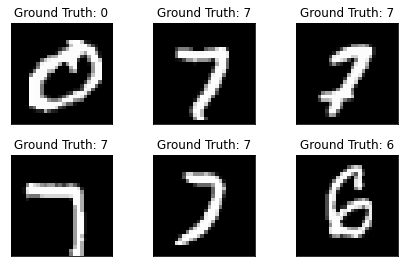

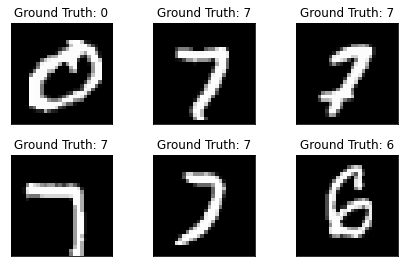

In [5]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
# View first batch and confirm shapes
dataset = enumerate(test_loader)
indx, (data, label) = next(dataset)
print(indx, data.shape, label.shape)

0 torch.Size([1000, 1, 28, 28]) torch.Size([1000])


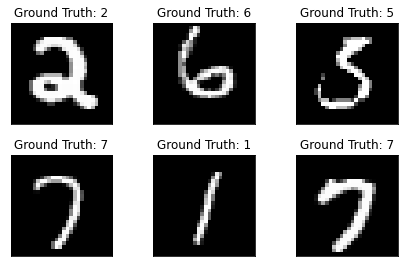

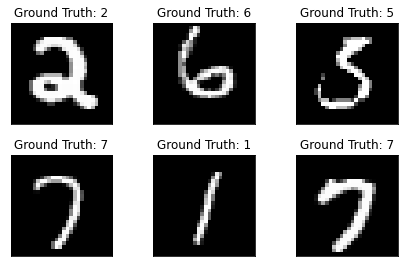

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [55]:
# Define Class
# i indx for v
# j indx for h
# weights i x j 
# bias a_i, b_j
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
class EFH:
    def __init__(self, n_visible, n_hidden, lr = 0.01, n_epochs = 5, steps=1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.steps = steps
        self.weights = torch.FloatTensor(torch.randn((self.n_hidden, self.n_visible))*0.01)
        self.bias_v = torch.FloatTensor(torch.zeros(self.n_visible))
        self.bias_h = torch.FloatTensor(torch.zeros(self.n_hidden))
        self.lr = lr
        self.m = 0.5 # momentum term
        self.decay = 0.001 # weight-decay term
        self.n_epochs = n_epochs

        print('EFH Constructed')

    def compute_hidden(self,  x):
        prob_hidden = torch.sigmoid(torch.matmul(x, self.weights.t()) + self.bias_h) 
        sampled_hidden = (torch.rand(prob_hidden.shape) < prob_hidden).float()
        return prob_hidden, torch.distributions.Bernoulli(prob_hidden).sample()

    def compute_visible(self, x):
        prob_visible = torch.sigmoid(torch.matmul(x, self.weights) + self.bias_v)
        sampled_visible = (torch.rand(prob_visible.shape) < prob_visible).float()
        return prob_visible, torch.distributions.Bernoulli(prob_visible).sample()

    def con_div(self, y):
        # Here, x is the batch
        x = deepcopy(y)
        #print(x.shape)
        #print()
        prob_hidden, state_hidden = self.compute_hidden(x)
        #for step in range(self.steps): # we only use 1-step here
        prob_visible, _ = self.compute_visible(state_hidden)
        prob_hidden_next, _ = self.compute_hidden(prob_visible)

        w1 = torch.matmul(state_hidden.t(), x)
        w2 = torch.matmul(prob_hidden_next.t(), prob_visible)
        
        # MOMENTUM 
        self.weights*=self.m 
        self.bias_v*=self.m
        self.bias_h*=self.m

        # UPDATE
        batch_size = x.shape[0]
        dw = w1-w2 #+ L2 * self.weights
        da = torch.sum(x-prob_visible, 0) #+ L2 * self.bias_v # visible bias
        db = torch.sum(prob_hidden-prob_hidden_next, 0) #+ L2 * self.bias_v # hidden bias

        self.weights+=((self.lr*dw)/batch_size) # multiply with batch
        self.bias_v+=((self.lr*da)/batch_size) 
        self.bias_h+=((self.lr*db)/batch_size) 

        # WEIGHT DECAY
        #self.weights*=(1-self.decay)
    
    def my_sigmoid(self, x):
        return 1./(1 + torch.exp(-x))

    def track_progress(self, x):
        prob_hidden, state_hidden = self.compute_hidden(x)
        prob_visible, _ = self.compute_visible(prob_hidden)
        error = (torch.mean((x-prob_visible)**2))/x.shape[0]
        return error

    def train(self):
        errors = []
        errors_test = []
        train_dataset = enumerate(train_loader)
        test_dataset = enumerate(test_loader)
        momentum_updated = False
        for epoch in range(self.n_epochs):
            error_batch = 0
            error_test_batch = 0

            # Training 
            #for indx, (b, label) in enumerate(train_loader):
            try:
                indx, (b, label) = next(train_dataset)
                b = b.view(len(b), self.n_visible)
                b.to(float)
                self.con_div(b) # Run Contrastive Divergence
                error_batch += self.track_progress(b) # Track Error
                errors.append(error_batch)
            except StopIteration:
                pass

            # Update Momentum Parameter if required
            if momentum_updated != True and len(errors) > 2 and abs(errors[-1]-errors[-2]) < 0.01:
                print('Momentum Updated!!')
                momentum_updated = True
                self.m = 0.95
            
            if (epoch+1)%20==0:
                print('Epoch:', epoch+1)
                print('Weight:', torch.norm(self.weights), torch.norm(self.bias_v), torch.norm(self.bias_h))
                print('Cumulative Error', error_batch)
            #self.lr/=(epoch+1)

        # Training Error Plot
        plt.figure()
        plt.plot(range(1, len(errors)+1), errors)
        #plt.plot(range(1, self.n_epochs+1), errors_test, label='Testing Error')
        plt.title('Reconstruction Training Error changing over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Reconstruction Training Error')
        #plt.legend()
        plt.show()

        # Test Error Computation

        for indx, (b, label) in enumerate(test_loader):
            b = b.view(b.shape[0], -1)
            if indx < 2:
                self.recon_images(b)
            error_test_batch += self.track_progress(b)


        print('Total Reconstruction Test Error', error_test_batch)


    def recon_images(self, x):
        prob_hidden, _ = self.compute_hidden(x)
        prob_visible, _ = self.compute_visible(prob_hidden)
        x = x.view(x.shape[0], 1, 28, 28)
        prob_visible = prob_visible.view(prob_visible.shape[0], 1, 28, 28)

        print('Reconstructed Images')
        fig = plt.figure()
        for j in range(25):
            plt.subplot(5, 5, j+1)
            plt.tight_layout()
            plt.imshow(prob_visible[j][0], cmap='gray', interpolation='none')
            plt.xticks([])
            plt.yticks([])
        plt.show()

        '''for i in range(25):
            plt.subplot(5, 5, i+1)
            plt.tight_layout()
            plt.imshow(x[i][0], cmap='gray', interpolation='none')
            plt.xticks([])
            plt.yticks([])
        plt.show()'''

 
        

EFH Constructed
Momentum Updated!!
Epoch: 20
Weight: tensor(10.4909) tensor(1.4091) tensor(0.1515)
Cumulative Error tensor(0.0065)
Epoch: 40
Weight: tensor(13.0753) tensor(1.6621) tensor(0.0980)
Cumulative Error tensor(0.0065)
Epoch: 60
Weight: tensor(13.9148) tensor(1.7417) tensor(0.0704)
Cumulative Error tensor(0.0064)
Epoch: 80
Weight: tensor(14.1641) tensor(1.7644) tensor(0.0637)
Cumulative Error tensor(0.0064)
Epoch: 100
Weight: tensor(14.2799) tensor(1.7753) tensor(0.0587)
Cumulative Error tensor(0.0063)
Epoch: 120
Weight: tensor(14.3116) tensor(1.7782) tensor(0.0585)
Cumulative Error tensor(0.0065)
Epoch: 140
Weight: tensor(14.2772) tensor(1.7731) tensor(0.0617)
Cumulative Error tensor(0.0064)
Epoch: 160
Weight: tensor(14.2774) tensor(1.7729) tensor(0.0611)
Cumulative Error tensor(0.0062)
Epoch: 180
Weight: tensor(14.3187) tensor(1.7775) tensor(0.0610)
Cumulative Error tensor(0.0062)
Epoch: 200
Weight: tensor(14.3338) tensor(1.7803) tensor(0.0553)
Cumulative Error tensor(0.0063)

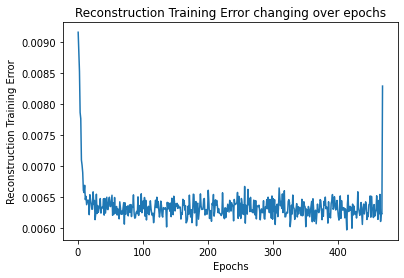

Reconstructed Images


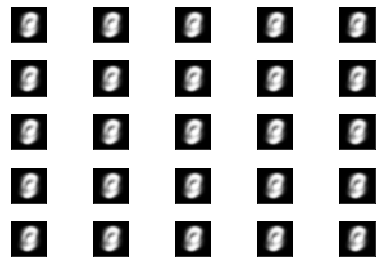

Reconstructed Images


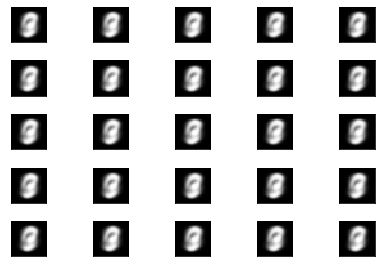

Total Reconstruction Test Error tensor(0.0081)


In [56]:
# Run EFH & Test
efh = EFH(n_visible=784, n_hidden=64, lr=0.01, n_epochs=500)
efh.train()
#efh.test()


In [37]:
train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform)
test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform)

indx = train_dataset.targets==1
train_dataset.targets = train_dataset.targets[indx]
train_dataset.data = train_dataset.data[indx]

indx = test_dataset.targets
test_dataset.targets = test_dataset.targets[indx]
test_dataset.data = test_dataset.data[indx]
#idx = (train_dataset.train_labels==1)
#dataset.train_labels = dataset.train_labels[idx]
#dataset.train_data = dataset.train_data[idx]

# import MNIST and load train/test dataloaders
#from torchvision import datasets, transforms
#transform = transforms.Compose([transforms.ToTensor(),
#                              transforms.Normalize((0.1307,), (0.3081,)),])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

EFH Constructed
Momentum Updated!!
Epoch: 20
Weight: tensor(3.3758) tensor(0.2227) tensor(0.0807)
Cumulative Error tensor(0.0045)
Epoch: 40
Weight: tensor(4.6520) tensor(0.2528) tensor(0.1128)
Cumulative Error tensor(0.0041)
Epoch: 60
Weight: tensor(4.9869) tensor(0.2564) tensor(0.1156)
Cumulative Error 0
Epoch: 80
Weight: tensor(4.9869) tensor(0.2564) tensor(0.1156)
Cumulative Error 0
Epoch: 100
Weight: tensor(4.9869) tensor(0.2564) tensor(0.1156)
Cumulative Error 0


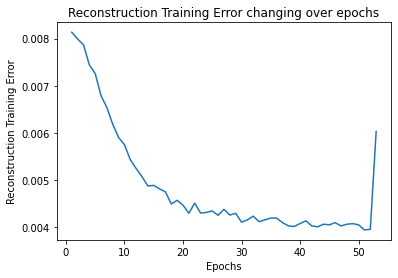

Reconstructed Images


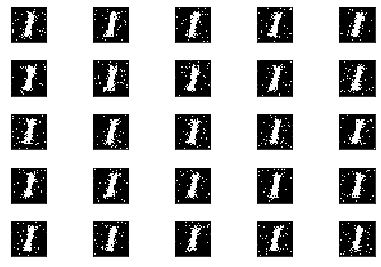

True Images


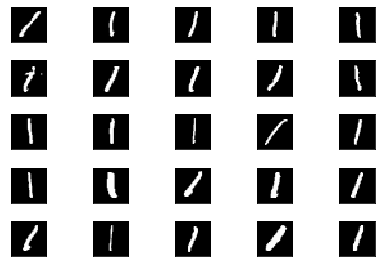

Reconstructed Images


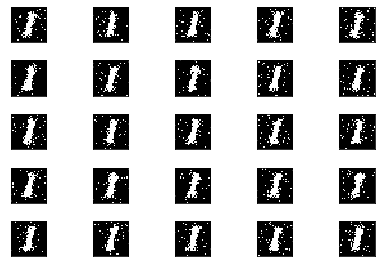

True Images


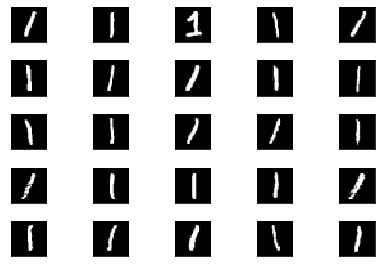

Total Reconstruction Test Error tensor(0.0043)


In [43]:
efh_1 = EFH(n_visible=784, n_hidden=20*20, lr=0.001, n_epochs=100)
efh_1.train()

In [155]:
# import MNIST and load train/test dataloaders
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),])
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform), batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform), batch_size=batch_size_test, shuffle=True)

In [156]:
class DBN:
    def __init__(self, n_layers, visible, hidden, epochs=10):
        self.hidden = hidden
        self.visible = visible
        self.n_layers = n_layers 
        self.RBM = []
        self.epochs = epochs
        for layer in range(n_layers):
            self.RBM.append(EFH(visible[layer], hidden[layer], lr=0.001, n_epochs=200))
            #self.RBMs[layer].train()

    def train(self):
        train_dataset = enumerate(train_loader)
        test_dataset = enumerate(test_loader)
        for epoch in range(self.epochs):
            
            indx, (batch, label) = next(train_dataset)
            #print(batch.shape)
            batch = batch.view(batch.shape[0], 784)

            prob_hidden = batch # start with original data
            #train iteratively
            for layer in range(self.n_layers):
                self.RBM[layer].con_div(prob_hidden) # train ith RBM
                prob_hidden, _ = self.RBM[layer].compute_hidden(prob_hidden) # get next hidden input
 
        # Testing with reconstruction
        for indx, (batch, label) in enumerate(test_loader):
            if indx > 2:
                break
            batch = batch.view(batch.shape[0], 784)
            prob_hidden = batch # input data
            for layer in range(self.n_layers):
                prob_hidden, _ = self.RBM[layer].compute_hidden(prob_hidden)

            prob_visible = prob_hidden

            for layer in range(self.n_layers-1, -1, -1): # prints images for each layer
                prob_visible, _ = self.RBM[layer].compute_visible(prob_visible)
                reconstructed_image = prob_visible

                # Reshape Image Data to plot
                true_shape = int(np.sqrt(self.visible[layer]))
                reconstructed_image = reconstructed_image.view(reconstructed_image.shape[0], 1, true_shape, true_shape)
                
            # Plot Reconstructed Data 
                print('Reconstruction at layer:', layer)
                fig = plt.figure()
                for i in range(25):
                    plt.subplot(5, 5, i+1)
                    plt.tight_layout()
                    plt.imshow(reconstructed_image[i][0], cmap='gray', interpolation='none')
                    plt.xticks([])
                    plt.yticks([])
                plt.show()

            batch = batch.view(batch.shape[0], 1, 28, 28)
            # Plot Original Data
            print('True Images')
            for i in range(25):
                plt.subplot(5, 5, i+1)
                plt.tight_layout()
                plt.imshow(batch[i][0], cmap='gray', interpolation='none')
                plt.xticks([])
                plt.yticks([])
            plt.show()
        

EFH Constructed
EFH Constructed
EFH Constructed
Reconstruction at layer: 2


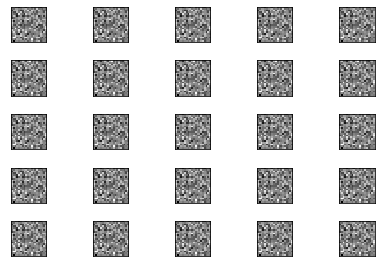

Reconstruction at layer: 1


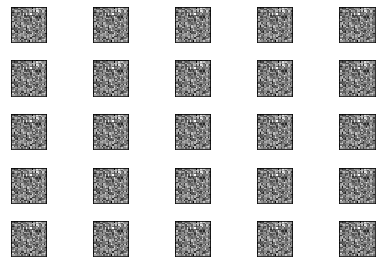

Reconstruction at layer: 0


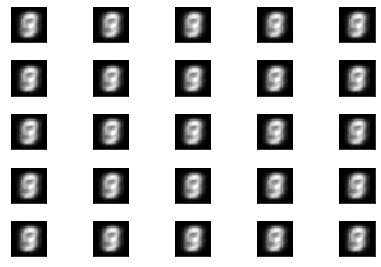

True Images


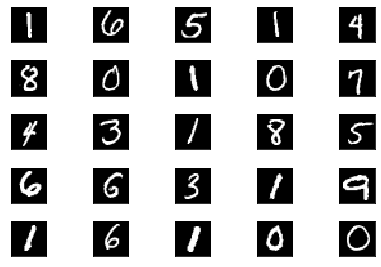

Reconstruction at layer: 2


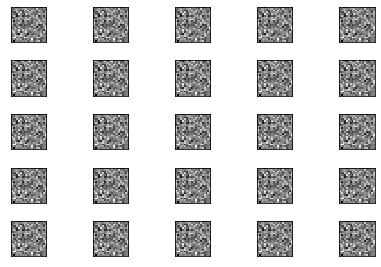

Reconstruction at layer: 1


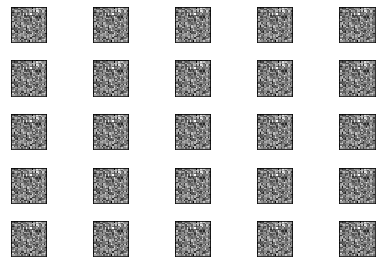

Reconstruction at layer: 0


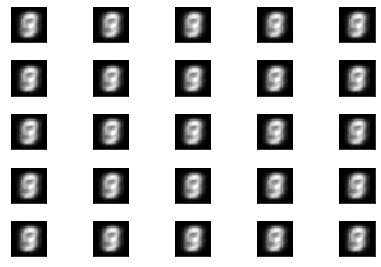

True Images


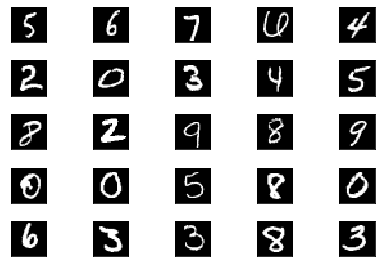

Reconstruction at layer: 2


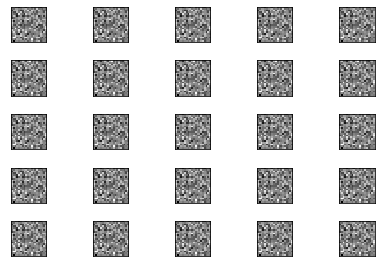

Reconstruction at layer: 1


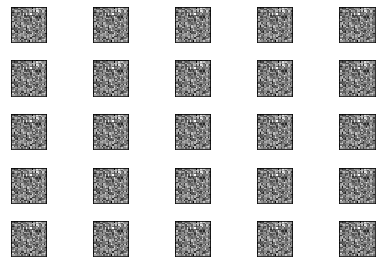

Reconstruction at layer: 0


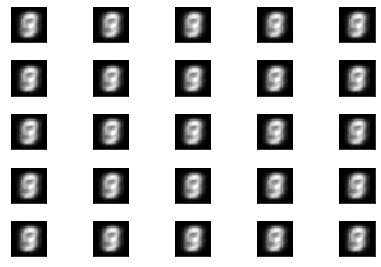

True Images


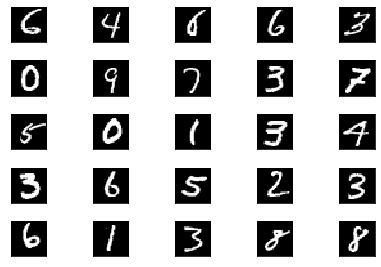

In [157]:
dbn = DBN(3, [784, 24*24, 20*20], [24*24, 20*20, 18*18])
dbn.train()

In [140]:
train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform)
test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform)

indx = train_dataset.targets==1
train_dataset.targets = train_dataset.targets[indx]
train_dataset.data = train_dataset.data[indx]

indx = test_dataset.targets==1
test_dataset.targets = test_dataset.targets[indx]
test_dataset.data = test_dataset.data[indx]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

EFH Constructed
EFH Constructed
EFH Constructed
Reconstruction at layer: 2


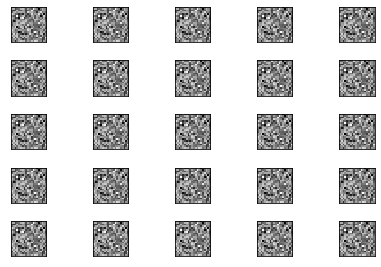

Reconstruction at layer: 1


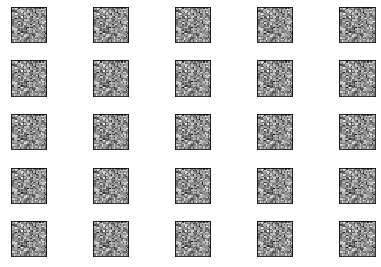

Reconstruction at layer: 0


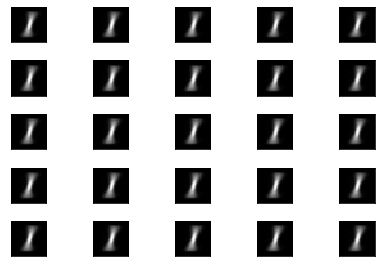

True Images


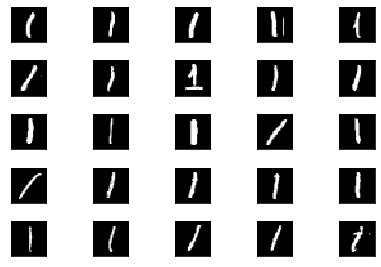

Reconstruction at layer: 2


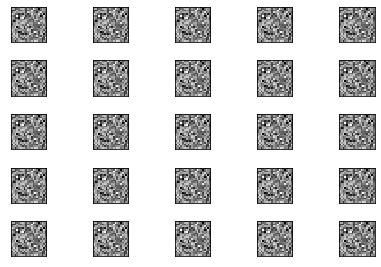

Reconstruction at layer: 1


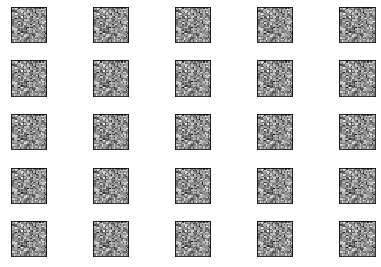

Reconstruction at layer: 0


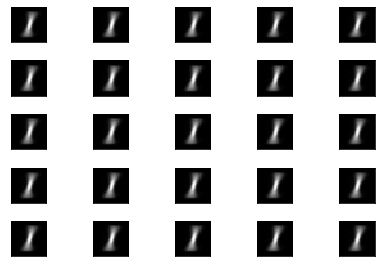

True Images


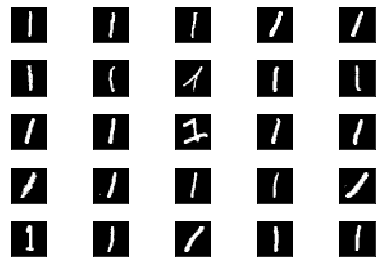

In [141]:
dbn_1 = DBN(3, [784, 24*24, 20*20], [24*24, 20*20, 18*18])
dbn_1.train()